In [41]:
import numpy as np
s = None

labels = []
datas = None

for line in open('/content/sample_data/mnist_test.csv', 'r'):
    a = list(map(int,line.split(',')))
    label = a[0]
    labels.append(label)
    data = np.array(a[1:]).reshape((1,28,28))
    if datas is None:
      datas = data
    else:
      datas = np.vstack((datas,data))
    if datas.shape[0] > 100:
      break

print(datas.shape)
print(len(labels))

(101, 28, 28)
101


In [137]:
import torch

class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, transform = None):
        self.transform = transform

        import numpy as np
        labels = []
        datas = None

        for line in open('/content/sample_data/mnist_test.csv', 'r'):
            a = list(map(int,line.split(',')))
            label = a[0]
            labels.append(label)
            data = np.array(a[1:],dtype = np.uint8).reshape((1,28,28))
            if datas is None:
              datas = data
            else:
              datas = np.vstack((datas,data))
            if datas.shape[0] > 10000:
              break

        self.data = datas
        self.label =  labels

        self.datanum = len(labels)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

In [138]:
import torchvision

trans = torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor()
                                        ])

dataset = Mydatasets(trans)

trainloader = torch.utils.data.DataLoader(dataset, batch_size = 100, shuffle = True, num_workers = 2)

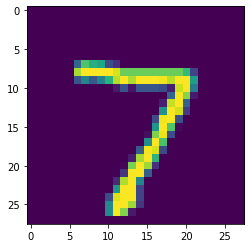

In [182]:
img = dataset[0][0].unsqueeze(dim = 0)
plt.imshow(img.squeeze().detach().numpy())

In [142]:
import torch.nn as nn
import torch.nn.functional as F

class My_VAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.fc1 = nn.Linear(64 * 24 * 24, 100)
    self.fc_mean = nn.Linear(100, 2)
    self.fc_var = nn.Linear(100, 2)

    self.dec_fc1 = nn.Linear(2, 100)
    self.dec_fc2 = nn.Linear(100, 100)
    self.dec_fc3 = nn.Linear(100, 28 * 28)
    
  def encoder(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = x.view(-1, 64 * 24 * 24)
    x = self.fc1(x)
    x = F.relu(x)
    mean = self.fc_mean(x)
    var = F.softplus(self.fc_var(x))
    return mean, var
    
  def sample_z(self, mean, var):
    epsilon = torch.randn(var.shape)
    return mean + torch.sqrt(var) * epsilon

  def decoder(self, z):
    x = self.dec_fc1(z)
    x = F.relu(x)
    x = self.dec_fc2(x)
    x = F.relu(x)
    x = self.dec_fc3(x)
    x = torch.sigmoid(x)
    return x

  def forward(self, x):
    shape = x.shape
    mean, var = self.encoder(x)
    z = self.sample_z(mean, var)
    x = self.decoder(z)
    x = x.view(*(shape)) # タプル展開
    return x

  def loss(self, x):
    shape = x.shape
    mean, var = self.encoder(x)
    KL = -0.5 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var))
    z = self.sample_z(mean, var)
    y = self.decoder(z)
    y = y.view(*(shape))
    torch.clamp(y,min = 0.01, max = 0.99)
    reconstruction = torch.mean(torch.sum(x * torch.log(y) + (1 - x) * torch.log(1 - y)))
    lower_bound = [-KL, reconstruction]
    return -sum(lower_bound)

In [202]:
vae = My_VAE()
optimizer = optim.Adam(vae.parameters(), lr=0.005)
losses = []

In [222]:
from tqdm.notebook import tqdm

with tqdm(range(100)) as pbar:
  for i in pbar:
    loss_epoch_sum = 0
    for x, label in trainloader:
      optimizer.zero_grad()
      loss = vae.loss(x)
      loss.backward()
      pbar.postfix = 'loss = {}'.format(float(loss))
      pbar.refresh()
      optimizer.step()
      loss_epoch_sum += float(loss)
    losses.append(loss_epoch_sum)
    print(loss_epoch_sum)

KeyboardInterrupt: ignored

In [218]:
img = dataset[200][0].unsqueeze(dim = 0)
y = vae(img)

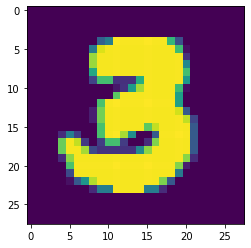

In [219]:
plt.imshow(img.squeeze().detach().numpy());

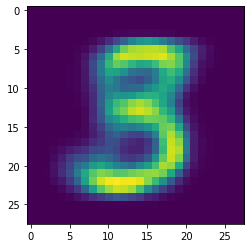

In [220]:
plt.imshow(y.squeeze().detach().numpy());